# DIISCO Top RL Interactions in CML

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import seaborn as sns
import pickle5 as pickle
import omnipath
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
import glob
import scanpy as sc

/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
days_to_dli = pd.read_excel('data/CML/sample_id_time_table.xlsx')
days_to_dli = days_to_dli[['Sample\nID', 'Time relative to\nDLI (days)']]
days_to_dli.columns = ['sample', 'days_to_DLI']
days_to_dli['sample'] = days_to_dli['sample'] + '_'

metadata_df = pd.read_csv('data/CML/run_CML/diisco_cml.csv', index_col='Unnamed: 0')
# Remove doublet clusters
metadata_df = metadata_df[~metadata_df['cluster_number'].isin([32, 34, 35, 43, 53])]
metadata_df = metadata_df.reset_index()
metadata_df = metadata_df[metadata_df['dataset'].str.contains('cml')]
metadata_df = pd.merge(metadata_df, days_to_dli, left_on='sample', right_on='sample')
metadata_df = metadata_df[metadata_df['days_to_DLI'] <= 1000]
metadata_df = metadata_df.set_index('index')

print(metadata_df.shape)
metadata_df.head()

(295324, 17)


,x,y,sample,cluster_number,dataset,patient,time,response,aml,DATA,celltypist,cml_Y,vireo,response_group,BM,diisco_cluster,days_to_DLI
index,,,,,,,,,,,,,,,,,
cmlnf_B1_120703409154483,12.231652,-4.257857,B1_,8,cml3,R5310,PRE,RESPONDER,x,CML,Mid erythroid,0.0,x,CML_R_PRE,BM,8,-27.0
cmlnf_B1_120703423539062,11.559934,-2.752673,B1_,8,cml3,R5310,PRE,RESPONDER,x,CML,Mid erythroid,1.0,x,CML_R_PRE,BM,8,-27.0
cmlnf_B1_120703423793573,6.153721,3.503655,B1_,33,cml3,R5310,PRE,RESPONDER,x,CML,Classical monocytes,1.0,x,CML_R_PRE,BM,CML2,-27.0
cmlnf_B1_120703424261363,10.377521,-4.252455,B1_,12,cml3,R5310,PRE,RESPONDER,x,CML,Mid erythroid,0.0,x,CML_R_PRE,BM,12,-27.0
cmlnf_B1_120703436605797,14.430582,2.945846,B1_,37,cml3,R5310,PRE,RESPONDER,x,CML,Megakaryocyte-erythroid-mast cell progenitor,1.0,x,CML_R_PRE,BM,37,-27.0


Load gene expression data

In [3]:
gene_exp_df = pickle.load(open('data/AML/data_df_with_controls.pkl', 'rb'))
genes = gene_exp_df.columns
gene_exp_df = pd.merge(metadata_df, gene_exp_df, left_on='index', right_index=True)
gene_exp_df = gene_exp_df[(gene_exp_df['days_to_DLI'] >= -200) & 
                          (gene_exp_df['days_to_DLI'] <= 400)]
# Filter outlier samples -200 days pre-DLI and +400 days post-DLI
metadata_df = metadata_df[(metadata_df['days_to_DLI'] >= -200) & 
                          (metadata_df['days_to_DLI'] <= 400)]
gene_exp_df = gene_exp_df.loc[metadata_df.index, genes]

print(metadata_df.shape)
print(gene_exp_df.shape)

(214994, 17)
(214994, 14582)


Filter genes with low expression

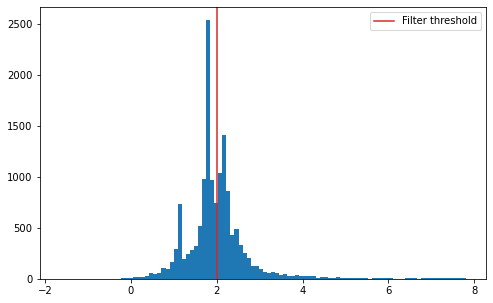

In [4]:
threshold = 2

plt.figure(figsize=(8, 5))
n, bins, _ = plt.hist(gene_exp_df.max(), bins=100)
plt.axvline(threshold, label='Filter threshold', c='tab:red')
plt.legend()

In [5]:
print("Percent genes removed:", (gene_exp_df.max() <= threshold).mean() * 100)

gene_filter = (gene_exp_df.max() > threshold)
gene_exp_df = gene_exp_df.loc[:, gene_filter]
gene_exp_df

Percent genes removed: 55.97311754217529


,NOC2L,HES4,ISG15,TNFRSF18,TNFRSF4,SDF4,UBE2J2,ACAP3,MXRA8,AURKAIP1,...,MT-CO2,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB
index,,,,,,,,,,,,,,,,,,,,,
cmlnf_B1_120703409154483,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,3.471740,-2.302585,2.714985,3.836513,2.353251,0.300375,2.794518,1.233815,-2.302585,2.687003
cmlnf_B1_120703423539062,-0.799746,-2.302585,-0.799746,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.403979,...,4.253314,-2.302585,3.346562,4.595043,3.111930,-2.302585,3.947730,1.738902,-0.224537,3.696003
cmlnf_B1_120703423793573,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.120957,...,1.723214,-2.302585,1.176896,2.761366,1.854512,-2.302585,1.970554,-2.302585,-2.302585,0.899436
cmlnf_B1_120703424261363,-2.302585,0.467766,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,3.839218,-2.302585,3.450778,3.901608,3.541473,-2.302585,3.541473,1.805941,-2.302585,2.490838
cmlnf_B1_120703436605797,-0.875458,-2.302585,-2.302585,-2.302585,-2.302585,-1.582032,-1.167596,-2.302585,-2.302585,-0.175665,...,2.587360,-2.302585,2.250721,2.216799,1.511471,-0.310143,2.761781,1.861507,-2.302585,2.216799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E7_TTTGTCACATGGTAGG,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.209983,-2.302585,-2.302585,-2.302585,-2.302585,...,3.217712,-2.302585,2.610170,2.842252,0.419497,1.871091,1.473294,1.755231,-0.209983,3.350743
E7_TTTGTCAGTAAGAGGA,-0.111118,-2.302585,-0.111118,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.111118,...,2.721416,0.910071,2.550798,2.179644,1.404666,1.734100,1.582888,1.734100,0.524531,2.721416
E7_TTTGTCAGTGTTGAGG,-2.302585,-2.302585,-0.871894,-2.302585,-2.302585,-0.871894,-2.302585,-2.302585,-2.302585,0.053044,...,2.646103,0.053044,2.086165,2.474172,1.706329,1.086347,1.706329,2.045860,1.086347,2.198163


Differentially expressed genes, by cluster

In [6]:
metadata_df = metadata_df[metadata_df['diisco_cluster'] != "27"]
gene_exp_df = gene_exp_df.loc[metadata_df.index]

In [7]:
gene_exp_adata = sc.AnnData(gene_exp_df.iloc[:, :-1], 
                            obs=metadata_df[['diisco_cluster']].astype('str'))
sc.tl.rank_genes_groups(gene_exp_adata, groupby='diisco_cluster', method='wilcoxon', key_added='wilcoxon', 
                        groups=['2', 'CML1'])

In [8]:
cluster_deg_df = sc.get.rank_genes_groups_df(gene_exp_adata, group="2", key='wilcoxon')
top_degs = cluster_deg_df[(cluster_deg_df['pvals_adj'] <= 0.01) & (cluster_deg_df['scores'] >= 0)]
top_degs.head(10)

,names,scores,logfoldchanges,pvals,pvals_adj
0,LTB,159.110168,NaN,0.0,0.0
1,TPT1,123.436775,1.078226,0.0,0.0
2,RPL10,123.216560,0.960056,0.0,0.0
3,RPL13,121.657761,0.921482,0.0,0.0
4,RPL30,119.298264,1.048030,0.0,0.0
5,RPL11,119.190086,1.013064,0.0,0.0
6,RPS27,118.962387,1.362357,0.0,0.0
7,TRAC,116.969627,NaN,0.0,0.0
8,CD3D,116.549477,NaN,0.0,0.0
9,IL7R,115.223259,-1.544522,0.0,0.0


In [9]:
cluster_to_degs = dict()
# clusters = sorted(metadata_df['diisco_cluster'].unique())
for cluster in ['2', 'CML1']:
    cluster_deg_df = sc.get.rank_genes_groups_df(gene_exp_adata, group=str(cluster), key='wilcoxon')
    top_degs = cluster_deg_df[(cluster_deg_df['pvals_adj'] <= 0.01) & 
                              (cluster_deg_df['scores'] >= 0)]
    cluster_to_degs[cluster] = {
        deg['names']: deg['pvals_adj']
        for index, deg in top_degs.iterrows()
    }

Load receptor-ligand pairs from Omnipath DB

In [10]:
rl_pairs = omnipath.interactions.LigRecExtra().get(genesymbols=True)
rl_pairs = rl_pairs.drop_duplicates(subset=['source_genesymbol', 'target_genesymbol'])
# rl_pairs.to_csv('data/RL_pairs/Omnipath_RL_pairs.csv', index=False)
# Filter RL pairs to genes in gene expression data
rl_pairs = rl_pairs[(rl_pairs['source_genesymbol'].isin(gene_exp_df.columns)) & 
                    (rl_pairs['target_genesymbol'].isin(gene_exp_df.columns))]
rl_pairs

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,references_stripped,n_references,n_sources,n_primary_sources
2,O60674,P19235,JAK2,EPOR,True,True,False,True,True,False,21,BioGRID:8343951;Cellinker:9030561;HPRD-phos:12...,BEL-Large-Corpus_ProtMapper;BioGRID;Cellinker;...,10579919;10660611;11443118;11779507;12027890;1...,13,22,14
8,P46531,P78504,NOTCH1,JAG1,True,True,False,False,False,False,16,Baccin2019:11006133;BioGRID:11006133;DIP:18660...,Baccin2019;BioGRID;CellCall;DIP;HPMR;HPRD;IntA...,11006133;16713569;17537801;18495817;18660822;2...,9,14,13
9,P78504,P46531,JAG1,NOTCH1,True,True,True,True,True,False,36,ACSN:22330899;ACSN:22363130;Baccin2019:7697721...,ACSN;Baccin2019;BioGRID;CellCall;CellChatDB;Ce...,10958687;11;11006133;15137944;16713569;1692140...,20,39,27
17,Q9H2A7,O00574,CXCL16,CXCR6,True,True,False,True,True,False,20,Baccin2019:11017100;Baccin2019:11290797;Baccin...,Baccin2019;CellCall;CellChatDB;CellPhoneDB;Cel...,11017100;11290797;14625285;22633458,4,32,20
21,P01579,P15260,IFNG,IFNGR1,True,True,False,True,True,False,58,Baccin2019:10811850;Baccin2019:10986460;Baccin...,Baccin2019;BioGRID;CellCall;CellTalkDB;DIP;DLR...,10811850;10860730;10986460;11250200;12165521;1...,27,33,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7735,O00602,Q07954,FCN1,LRP1,True,False,False,False,False,False,0,NaN,EMBRACE,None,None,1,1
7743,P19883,P01137,FST,TGFB1,True,True,True,True,True,True,0,NaN,CellChatDB-cofactors;Wang,None,None,2,2
7744,Q9Y6C2,P01137,EMILIN1,TGFB1,True,False,True,True,False,True,6,ACSN:14557817;ACSN:16474430;ACSN:17934056;ACSN...,ACSN;CellChatDB-cofactors,14557817;16474430;17934056;20519943;21900405;2...,6,2,2
7746,P08476,P01137,INHBA,TGFB1,True,False,True,True,False,True,0,NaN,CellChatDB-cofactors;Wang,None,None,2,2


Filter gene expressions to RL genes only

In [11]:
all_rl_genes = set(pd.concat([rl_pairs['source_genesymbol'], rl_pairs['target_genesymbol']]))

gene_exp_df = gene_exp_df.loc[:, gene_exp_df.columns.isin(all_rl_genes)]
gene_exp_df

,TNFRSF4,TNFRSF14,TNFRSF25,AGTRAP,TNFRSF1B,HSPG2,C1QA,C1QB,CNR2,TMEM222,...,APP,IFNAR2,IL10RB,IFNAR1,IFNGR2,ICOSLG,ITGB2,COL6A1,COL6A2,DIP2A
index,,,,,,,,,,,,,,,,,,,,,
cmlnf_B1_120703409154483,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
cmlnf_B1_120703423539062,-2.302585,-2.302585,-2.302585,-0.799746,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
cmlnf_B1_120703423793573,-2.302585,-2.302585,-2.302585,-0.120957,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-0.120957,-0.120957,0.514107,-2.302585,0.899436,-2.302585,-2.302585,-2.302585
cmlnf_B1_120703424261363,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
cmlnf_B1_120703436605797,-2.302585,-2.302585,-2.302585,-1.582032,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.649651,...,-1.167596,-1.582032,-2.302585,-2.302585,-1.582032,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E7_TTTGTCACATGGTAGG,-2.302585,0.419497,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-0.209983,-2.302585,-2.302585,0.802805,-2.302585,-2.302585,-2.302585
E7_TTTGTCAGTAAGAGGA,-2.302585,-0.111118,-2.302585,-0.111118,-0.111118,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-0.111118,-2.302585,-0.111118,-2.302585,-2.302585,1.582888,-2.302585,-2.302585,0.524531
E7_TTTGTCAGTGTTGAGG,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-0.306094,-0.871894,-2.302585,-2.302585,-0.871894,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585


## Responders

In [12]:
gene_exp_responders_df = gene_exp_df[metadata_df['response'] == 'RESPONDER']
metadata_responders_df = metadata_df[metadata_df['response'] == 'RESPONDER']
gene_exp_responders_df

,TNFRSF4,TNFRSF14,TNFRSF25,AGTRAP,TNFRSF1B,HSPG2,C1QA,C1QB,CNR2,TMEM222,...,APP,IFNAR2,IL10RB,IFNAR1,IFNGR2,ICOSLG,ITGB2,COL6A1,COL6A2,DIP2A
index,,,,,,,,,,,,,,,,,,,,,
cmlnf_B1_120703409154483,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
cmlnf_B1_120703423539062,-2.302585,-2.302585,-2.302585,-0.799746,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
cmlnf_B1_120703423793573,-2.302585,-2.302585,-2.302585,-0.120957,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-0.120957,-0.120957,0.514107,-2.302585,0.899436,-2.302585,-2.302585,-2.302585
cmlnf_B1_120703424261363,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
cmlnf_B1_120703436605797,-2.302585,-2.302585,-2.302585,-1.582032,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.649651,...,-1.167596,-1.582032,-2.302585,-2.302585,-1.582032,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E7_TTTGTCACATGGTAGG,-2.302585,0.419497,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-0.209983,-2.302585,-2.302585,0.802805,-2.302585,-2.302585,-2.302585
E7_TTTGTCAGTAAGAGGA,-2.302585,-0.111118,-2.302585,-0.111118,-0.111118,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-0.111118,-2.302585,-0.111118,-2.302585,-2.302585,1.582888,-2.302585,-2.302585,0.524531
E7_TTTGTCAGTGTTGAGG,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-0.306094,-0.871894,-2.302585,-2.302585,-0.871894,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585


In [13]:
X_test = np.load('data/CML/X_R.npy')
X_test_pre_500_days = (X_test <= 500).flatten()
X_test = X_test[X_test_pre_500_days]

y_preds = np.load('data/CML/y_preds_R.npy')[X_test_pre_500_days]

W_samples_predict = np.load('data/CML/W_samples_predict_R.npy')
W = W_samples_predict.mean(axis=0)[X_test_pre_500_days]

clusters_of_interest = {
    '0': 'T cell',
    '1': 'NK cell',
    '11': 'Erythroid',
    '12': 'Erythroid',
    '13': 'NK cell',
    '14': 'B cell',
    '15': 'AML',
    '16': 'Erythroid',
    '17': 'Myeloid',
    '2': 'T cell',
    '20': 'B cell',
    '23': 'B cell',
    '24': 'Myeloid',
    '3': 'B cell',
    '4': 'Myeloid',
    '5': 'T cell',
    '8': 'Erythroid',
    '9': 'Myeloid', 
    'CML1': 'CML'
}

Text(0.5, 1.0, '$\\hat{W}_{avg}$ (200 days post DLI)')

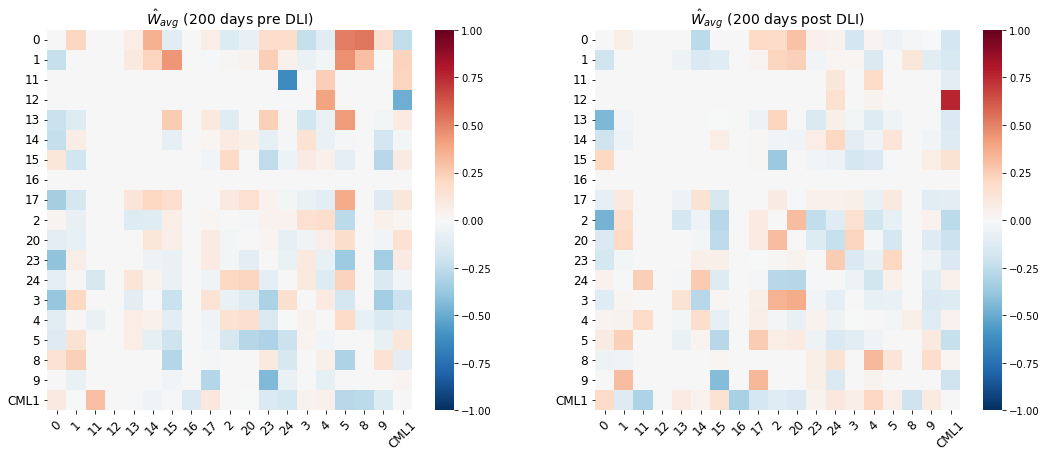

In [14]:
vmin = -1
vmax = 1

X_200_days_pre_dli_index = np.where(X_test > -200)[0][0]
X_post_dli_index = np.where(X_test > 0)[0][0]
X_200_days_post_dli_index = np.where(X_test > 200)[0][0]
X_post_dli_index

W_pre_dli = W[X_200_days_pre_dli_index:X_post_dli_index]
W_post_dli = W[X_post_dli_index:X_200_days_post_dli_index]
W_pre_dli_avg_over_time = np.mean(W_pre_dli, axis=0)
W_post_dli_avg_over_time = np.mean(W_post_dli, axis=0)

plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
ax = sns.heatmap(W_pre_dli_avg_over_time, cmap="RdBu_r", annot=False, 
                 fmt='.2f', vmin=vmin, vmax=vmax)
ax.set_yticklabels(clusters_of_interest, fontsize=12)
ax.set_xticklabels(clusters_of_interest, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('$\hat{W}_{avg}$ (200 days pre DLI)', fontsize=14)

plt.subplot(1, 2, 2)
ax = sns.heatmap(W_post_dli_avg_over_time, cmap="RdBu_r", annot=False, 
                 fmt='.2f', vmin=vmin, vmax=vmax)
ax.set_yticklabels(clusters_of_interest, fontsize=12)
ax.set_xticklabels(clusters_of_interest, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('$\hat{W}_{avg}$ (200 days post DLI)', fontsize=14)

In [15]:
source_cluster = '2'
target_cluster = 'CML1'

source_cluster_index = list(clusters_of_interest).index(source_cluster)
target_cluster_index = list(clusters_of_interest).index(target_cluster)

Text(0.5, 1.0, 'Cluster 2 --> CML1 interaction (abs val)')

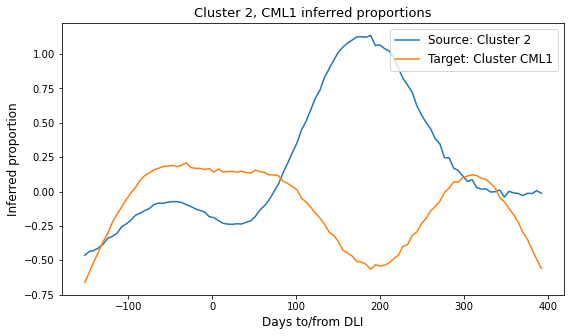

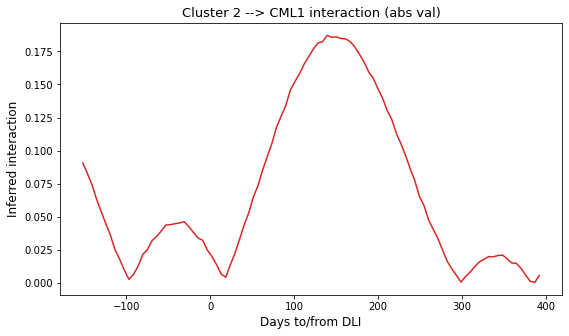

In [16]:
plt.figure(figsize=(9, 5))
plt.plot(X_test, y_preds[:, source_cluster_index], label=f'Source: Cluster {source_cluster}')
plt.plot(X_test, y_preds[:, target_cluster_index], label=f'Target: Cluster {target_cluster}')
plt.ylabel('Inferred proportion', fontsize=12)
plt.xlabel('Days to/from DLI', fontsize=12)
plt.title(f'Cluster {source_cluster}, {target_cluster} inferred proportions', fontsize=13)
plt.legend(loc='upper right', fontsize=12)

plt.figure(figsize=(9, 5))
plt.plot(X_test, np.abs(W[:, target_cluster_index, source_cluster_index]), color='tab:red')
plt.ylabel('Inferred interaction', fontsize=12)
plt.xlabel('Days to/from DLI', fontsize=12)
plt.title(f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)', fontsize=13)

In [58]:
source_cluster_cells = gene_exp_responders_df[metadata_responders_df['diisco_cluster'] == source_cluster]
source_cluster_cells

,TNFRSF4,TNFRSF14,TNFRSF25,AGTRAP,TNFRSF1B,HSPG2,C1QA,C1QB,CNR2,TMEM222,...,APP,IFNAR2,IL10RB,IFNAR1,IFNGR2,ICOSLG,ITGB2,COL6A1,COL6A2,DIP2A
index,,,,,,,,,,,,,,,,,,,,,
cmlnf_B1_120786772684084,-2.302585,-2.302585,-0.576349,-0.576349,-0.576349,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
cmlnf_B1_120786772715955,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
cmlnf_B1_120786773294300,-2.302585,-0.421462,-2.302585,-2.302585,-0.421462,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-0.421462,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
cmlnf_B1_121202296416110,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.546939,-2.302585,-2.302585,-2.302585
cmlnf_B1_121202342484789,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E7_TTTATGCGTTACGCGC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-0.352896,-0.352896,-2.302585,-0.352896,-2.302585,-2.302585,-2.302585
E7_TTTCCTCCAATCAGAA,-0.517434,0.088099,0.088099,-2.302585,-0.517434,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-0.517434,-2.302585,-2.302585,-2.302585,0.947883,-2.302585,-2.302585,-2.302585
E7_TTTGCGCGTCCAGTGC,-2.302585,-2.302585,-0.194344,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.436156,-2.302585,-2.302585,-2.302585


In [59]:
target_cluster_cells = gene_exp_responders_df[metadata_responders_df['diisco_cluster'] == target_cluster]
target_cluster_cells

,TNFRSF4,TNFRSF14,TNFRSF25,AGTRAP,TNFRSF1B,HSPG2,C1QA,C1QB,CNR2,TMEM222,...,APP,IFNAR2,IL10RB,IFNAR1,IFNGR2,ICOSLG,ITGB2,COL6A1,COL6A2,DIP2A
index,,,,,,,,,,,,,,,,,,,,,
cmlnf_B1_120703436609382,-2.302585,-1.806586,-1.476536,-1.806586,-2.302585,-1.806586,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-1.476536,-2.302585,-2.302585,-1.476536,-2.302585,-1.030425,-2.302585,-2.302585,-2.302585
cmlnf_B1_120703455520678,-2.302585,-2.302585,-1.199849,-1.789283,-1.451751,-1.451751,-2.302585,-2.302585,-2.302585,-1.789283,...,-1.789283,-0.831491,-1.789283,-2.302585,-0.831491,-2.302585,-1.789283,-2.302585,-2.302585,-2.302585
cmlnf_B1_120772933569462,-2.302585,-1.258540,-2.302585,-2.302585,-1.258540,-1.650082,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-1.650082,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
cmlnf_B1_120786758285749,-1.672975,-1.672975,-1.013177,-2.302585,-1.672975,-1.672975,-2.302585,-2.302585,-2.302585,-1.672975,...,-2.302585,-2.302585,-2.302585,-1.672975,-2.302585,-2.302585,-1.672975,-2.302585,-2.302585,-2.302585
cmlnf_B1_120797913007979,-2.302585,-1.428564,-2.302585,-2.302585,-2.302585,-0.969413,-2.302585,-2.302585,-2.302585,-1.428564,...,-1.428564,-1.428564,-2.302585,-2.302585,-2.302585,-2.302585,-1.428564,-2.302585,-2.302585,-2.302585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E7_TTCGAAGTCTTATCTG,-2.302585,-2.302585,-2.302585,-2.302585,-1.011494,-2.302585,-2.302585,-2.302585,-2.302585,-1.011494,...,-2.302585,-1.461718,-2.302585,-1.461718,-0.466250,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
E7_TTCTCAAGTCTAGCGC,-2.302585,-1.790968,-1.790968,-1.454157,-1.790968,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-0.566355,-1.790968,-1.202654,-1.790968,-2.302585,-2.302585,-2.302585,-2.302585,-1.790968
E7_TTCTCCTTCGCCAGCA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-1.350216,...,-2.302585,-1.350216,-1.350216,-0.871392,-2.302585,-2.302585,-1.350216,-2.302585,-2.302585,-1.350216


Filter down to differentially-expressed RL genes per cluster

In [60]:
source_cluster_degs = cluster_to_degs[source_cluster]
target_cluster_degs = cluster_to_degs[target_cluster]

Sliding window mean of ligand and receptor expression at DLI time points

In [61]:
min_exp_threshold = -5
sliding_window_length = 2

source_target_inferred_interaction_abs_val = np.abs(W[:, target_cluster_index, source_cluster_index])

ligand_receptor_corrs_with_interaction = []
for index, rl_pair in tqdm_notebook(list(rl_pairs.iterrows())):
    ligand_gene = rl_pair['source_genesymbol']
    receptor_gene = rl_pair['target_genesymbol']
    # Filter to differentially-expressed RL genes
    if (ligand_gene not in source_cluster_degs or receptor_gene not in target_cluster_degs):
        continue
    # Model for ligand gene expression
    ligand_gene_exp = source_cluster_cells.loc[source_cluster_cells[ligand_gene] > min_exp_threshold, ligand_gene]
    ligand_days_to_dli = metadata_responders_df.loc[ligand_gene_exp.index, 'days_to_DLI']
    days_to_dli = sorted(ligand_days_to_dli.unique())
    if len(days_to_dli) < sliding_window_length: continue
    sliding_window_mean_ligand_gene_exp = pd.Series({
        days: ligand_gene_exp[ligand_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
        for i, days in enumerate(days_to_dli)
    })
    ligand_closest_Xs_to_dli_dates = np.array([], dtype='int')
    for days in sliding_window_mean_ligand_gene_exp.index:
        closest_X = np.argmin(np.abs(X_test - days))
        ligand_closest_Xs_to_dli_dates = np.append(ligand_closest_Xs_to_dli_dates, closest_X)
    # Model for receptor gene expression
    receptor_gene_exp = target_cluster_cells.loc[target_cluster_cells[receptor_gene] > min_exp_threshold, receptor_gene]
    receptor_days_to_dli = metadata_responders_df.loc[receptor_gene_exp.index, 'days_to_DLI']
    days_to_dli = sorted(receptor_days_to_dli.unique())
    if len(days_to_dli) < sliding_window_length: continue
    sliding_window_mean_receptor_gene_exp = pd.Series({
        days: receptor_gene_exp[receptor_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
        for i, days in enumerate(days_to_dli)
    })
    receptor_closest_Xs_to_dli_dates = np.array([], dtype='int')
    for days in sliding_window_mean_receptor_gene_exp.index:
        closest_X = np.argmin(np.abs(X_test - days))
        receptor_closest_Xs_to_dli_dates = np.append(receptor_closest_Xs_to_dli_dates, closest_X)
    # Correlations b/w ligand/receptor gene expression and inferred interaction
    ligand_interaction_corr = np.corrcoef(sliding_window_mean_ligand_gene_exp.dropna(), 
                                source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates][sliding_window_length-1:])
    receptor_interaction_corr = np.corrcoef(sliding_window_mean_receptor_gene_exp.dropna(), 
                                    source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_dli_dates][sliding_window_length-1:])
    ligand_receptor_corrs_with_interaction.append({
        'Ligand': ligand_gene,
        'Ligand-interaction correlation': ligand_interaction_corr[0, 1],
        'Ligand DEG pval': source_cluster_degs[ligand_gene],
        'Receptor': receptor_gene,
        'Receptor-interaction correlation': receptor_interaction_corr[0, 1],
        'Receptor DEG pval': target_cluster_degs[receptor_gene],
        'Avg ligand/receptor-interaction correlation': (ligand_interaction_corr[0, 1] + receptor_interaction_corr[0, 1]) / 2
    })
    

  0%|          | 0/988 [00:00<?, ?it/s]

In [62]:
ligand_receptor_corrs_with_interaction_df = pd.DataFrame(ligand_receptor_corrs_with_interaction)
ligand_receptor_corrs_with_interaction_df = ligand_receptor_corrs_with_interaction_df.sort_values('Avg ligand/receptor-interaction correlation', ascending=False)
ligand_receptor_corrs_with_interaction_df = ligand_receptor_corrs_with_interaction_df.reset_index(drop=True)
ligand_receptor_corrs_with_interaction_df.head(30)

,Ligand,Ligand-interaction correlation,Ligand DEG pval,Receptor,Receptor-interaction correlation,Receptor DEG pval,Avg ligand/receptor-interaction correlation
0,ADGRE5,0.418173,5.086656e-05,CD55,0.668381,0.000000e+00,0.543277
1,CD7,0.427014,0.000000e+00,ADAM15,0.640711,1.252819e-201,0.533862
2,UBC,0.285669,2.235209e-89,LDLR,0.736689,1.776231e-65,0.511179
3,CD55,0.228820,1.052732e-04,ADGRE2,0.701725,1.276358e-03,0.465273
4,HLA-B,0.356585,0.000000e+00,CANX,0.551356,0.000000e+00,0.453971
5,HSPA8,0.140012,4.355774e-251,LDLR,0.736689,1.776231e-65,0.438351
6,LTA,0.311683,6.787495e-25,LTBR,0.557821,0.000000e+00,0.434752
7,IL6ST,0.749920,6.921827e-49,EPOR,0.099598,0.000000e+00,0.424759
8,CD96,0.432744,7.834032e-131,NECTIN2,0.405551,4.696800e-19,0.419148
9,TNF,0.177383,3.607272e-04,FAS,0.645939,1.353963e-75,0.411661


In [63]:
ligand_receptor_corrs_with_interaction_df = ligand_receptor_corrs_with_interaction_df.head(30)
ligand_receptor_corrs_with_interaction_df.to_excel(f'data/CML/DIISCO_CML_top_RL_pairs_R/{source_cluster} --> {target_cluster}.xlsx', 
                                                    sheet_name='R',
                                                    index=False)

In [64]:
ligand_gene = 'ADGRE5'
receptor_gene = 'CD55'

min_exp_threshold = -5
sliding_window_length = 2

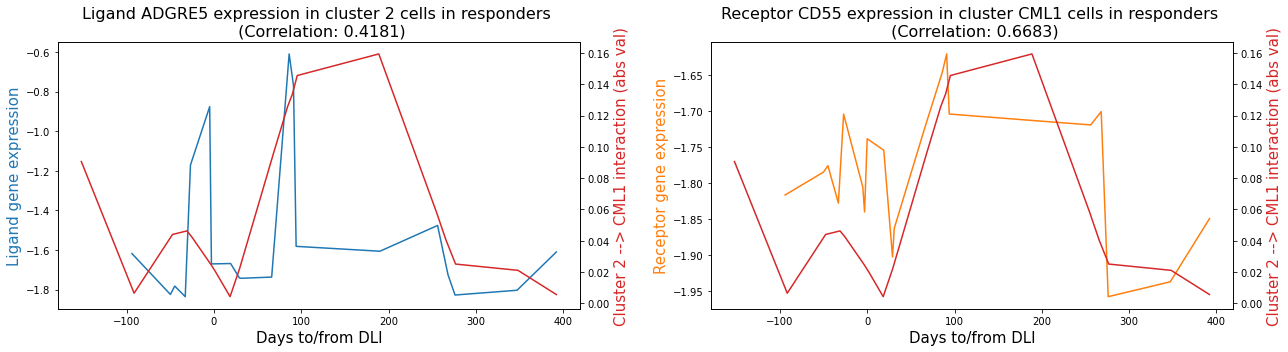

In [65]:
min_exp_threshold = -5

source_target_inferred_interaction_abs_val = np.abs(W[:, target_cluster_index, source_cluster_index])

ligand_gene_exp = source_cluster_cells.loc[source_cluster_cells[ligand_gene] > min_exp_threshold, ligand_gene]
ligand_days_to_dli = metadata_responders_df.loc[ligand_gene_exp.index, 'days_to_DLI']
days_to_dli = sorted(ligand_days_to_dli.unique())
sliding_window_mean_ligand_gene_exp = pd.Series({
    days: ligand_gene_exp[ligand_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
    for i, days in enumerate(days_to_dli)
})
ligand_closest_Xs_to_dli_dates = np.array([], dtype='int')
for days in sliding_window_mean_ligand_gene_exp.index:
    closest_X = np.argmin(np.abs(X_test - days))
    ligand_closest_Xs_to_dli_dates = np.append(ligand_closest_Xs_to_dli_dates, closest_X)
ligand_interaction_corr = np.corrcoef(sliding_window_mean_ligand_gene_exp.dropna(), 
                                source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates][sliding_window_length-1:])

plt.figure(figsize=(18, 5))
ax1 = plt.subplot(1, 2, 1)
ax2 = ax1.twinx()
# ax1.scatter(ligand_days_to_dli, ligand_gene_exp, color='tab:blue', alpha=0.3)
ax1.plot(sliding_window_mean_ligand_gene_exp.index, 
         sliding_window_mean_ligand_gene_exp, 
         color='tab:blue')
ax1.set_ylabel('Ligand gene expression', fontsize=15, color='tab:blue')
ax2.plot(X_test[ligand_closest_Xs_to_dli_dates], 
         source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates], color='tab:red')
ax2.set_ylabel(f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)',
               fontsize=15, color='tab:red')
ax1.set_xlabel('Days to/from DLI', fontsize=15)
plt.title(f'Ligand {ligand_gene} expression in cluster {source_cluster} cells in responders \n (Correlation: {str(ligand_interaction_corr[0, 1])[:6]})', 
          fontsize=16)

receptor_gene_exp = target_cluster_cells.loc[target_cluster_cells[receptor_gene] > min_exp_threshold, receptor_gene]
receptor_days_to_dli = metadata_responders_df.loc[receptor_gene_exp.index, 'days_to_DLI']
days_to_dli = sorted(receptor_days_to_dli.unique())
sliding_window_mean_receptor_gene_exp = pd.Series({
    days: receptor_gene_exp[receptor_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
    for i, days in enumerate(days_to_dli)
})
receptor_closest_Xs_to_dli_dates = np.array([], dtype='int')
for days in sliding_window_mean_receptor_gene_exp.index:
    closest_X = np.argmin(np.abs(X_test - days))
    receptor_closest_Xs_to_dli_dates = np.append(receptor_closest_Xs_to_dli_dates, closest_X)
receptor_interaction_corr = np.corrcoef(sliding_window_mean_receptor_gene_exp.dropna(), 
                                source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_dli_dates][sliding_window_length-1:])

ax1 = plt.subplot(1, 2, 2)
ax2 = ax1.twinx()
# ax1.scatter(receptor_days_to_dli, receptor_gene_exp, color='tab:orange', alpha=0.3)
ax1.plot(sliding_window_mean_receptor_gene_exp.index, 
         sliding_window_mean_receptor_gene_exp, 
         color='tab:orange')
ax1.set_ylabel('Receptor gene expression', fontsize=15, color='tab:orange')
ax2.plot(X_test[receptor_closest_Xs_to_dli_dates], 
         source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_dli_dates], color='tab:red')
ax2.set_ylabel(f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)',
               fontsize=15, color='tab:red')
ax1.set_xlabel('Days to/from DLI', fontsize=15)
plt.title(f'Receptor {receptor_gene} expression in cluster {target_cluster} cells in responders \n (Correlation: {str(receptor_interaction_corr[0, 1])[:6]})', 
          fontsize=16)
plt.tight_layout()
plt.subplots_adjust(wspace=0.25)

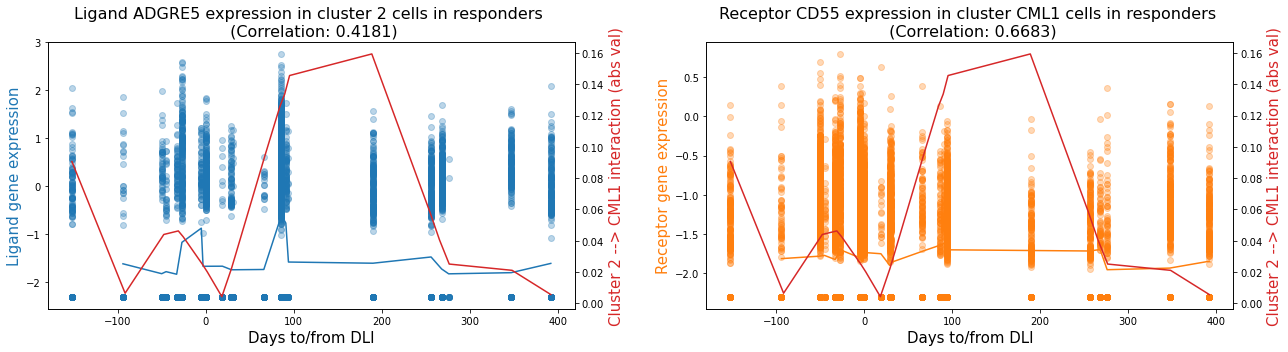

In [66]:
source_target_inferred_interaction_abs_val = np.abs(W[:, target_cluster_index, source_cluster_index])

ligand_gene_exp = source_cluster_cells.loc[source_cluster_cells[ligand_gene] > min_exp_threshold, ligand_gene]
ligand_days_to_dli = metadata_responders_df.loc[ligand_gene_exp.index, 'days_to_DLI']
days_to_dli = sorted(ligand_days_to_dli.unique())
sliding_window_mean_ligand_gene_exp = pd.Series({
    days: ligand_gene_exp[ligand_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
    for i, days in enumerate(days_to_dli)
})
ligand_closest_Xs_to_dli_dates = np.array([], dtype='int')
for days in sliding_window_mean_ligand_gene_exp.index:
    closest_X = np.argmin(np.abs(X_test - days))
    ligand_closest_Xs_to_dli_dates = np.append(ligand_closest_Xs_to_dli_dates, closest_X)
ligand_interaction_corr = np.corrcoef(sliding_window_mean_ligand_gene_exp.dropna(), 
                                source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates][sliding_window_length-1:])

plt.figure(figsize=(18, 5))
ax1 = plt.subplot(1, 2, 1)
ax2 = ax1.twinx()
ax1.scatter(ligand_days_to_dli, ligand_gene_exp, color='tab:blue', alpha=0.3)
ax1.plot(sliding_window_mean_ligand_gene_exp.index, 
         sliding_window_mean_ligand_gene_exp, 
         color='tab:blue')
ax1.set_ylabel('Ligand gene expression', fontsize=15, color='tab:blue')
ax2.plot(X_test[ligand_closest_Xs_to_dli_dates], 
         source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates], color='tab:red')
ax2.set_ylabel(f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)',
               fontsize=15, color='tab:red')
ax1.set_xlabel('Days to/from DLI', fontsize=15)
plt.title(f'Ligand {ligand_gene} expression in cluster {source_cluster} cells in responders \n (Correlation: {str(ligand_interaction_corr[0, 1])[:6]})', 
          fontsize=16)

receptor_gene_exp = target_cluster_cells.loc[target_cluster_cells[receptor_gene] > min_exp_threshold, receptor_gene]
receptor_days_to_dli = metadata_responders_df.loc[receptor_gene_exp.index, 'days_to_DLI']
days_to_dli = sorted(receptor_days_to_dli.unique())
sliding_window_mean_receptor_gene_exp = pd.Series({
    days: receptor_gene_exp[receptor_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
    for i, days in enumerate(days_to_dli)
})
receptor_closest_Xs_to_dli_dates = np.array([], dtype='int')
for days in sliding_window_mean_receptor_gene_exp.index:
    closest_X = np.argmin(np.abs(X_test - days))
    receptor_closest_Xs_to_dli_dates = np.append(receptor_closest_Xs_to_dli_dates, closest_X)
receptor_interaction_corr = np.corrcoef(sliding_window_mean_receptor_gene_exp.dropna(), 
                                source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_dli_dates][sliding_window_length-1:])

ax1 = plt.subplot(1, 2, 2)
ax2 = ax1.twinx()
ax1.scatter(receptor_days_to_dli, receptor_gene_exp, color='tab:orange', alpha=0.3)
ax1.plot(sliding_window_mean_receptor_gene_exp.index, 
         sliding_window_mean_receptor_gene_exp, 
         color='tab:orange')
ax1.set_ylabel('Receptor gene expression', fontsize=15, color='tab:orange')
ax2.plot(X_test[receptor_closest_Xs_to_dli_dates], 
         source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_dli_dates], color='tab:red')
ax2.set_ylabel(f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)',
               fontsize=15, color='tab:red')
ax1.set_xlabel('Days to/from DLI', fontsize=15)
plt.title(f'Receptor {receptor_gene} expression in cluster {target_cluster} cells in responders \n (Correlation: {str(receptor_interaction_corr[0, 1])[:6]})', 
          fontsize=16)
plt.tight_layout()
plt.subplots_adjust(wspace=0.25)

Ligand: ADGRE5
Receptor: CD55
Ligand-interaction correlation: 0.4181
Receptor-interaction correlation: 0.6683
Avg ligand/receptor-interaction correlation: 0.5432


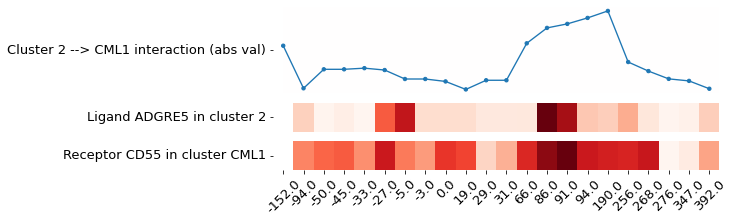

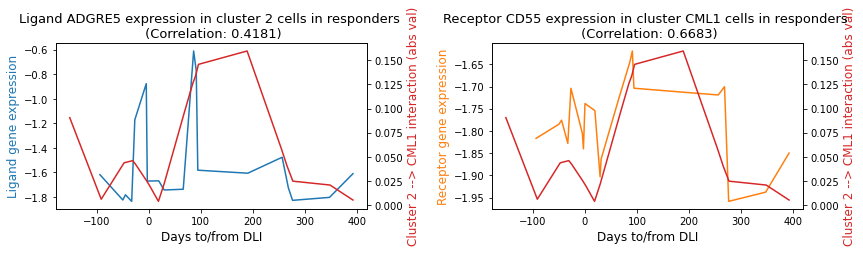



Ligand: CD7
Receptor: ADAM15
Ligand-interaction correlation: 0.4270
Receptor-interaction correlation: 0.6407
Avg ligand/receptor-interaction correlation: 0.5338


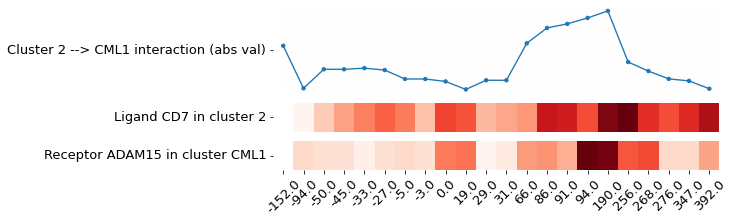

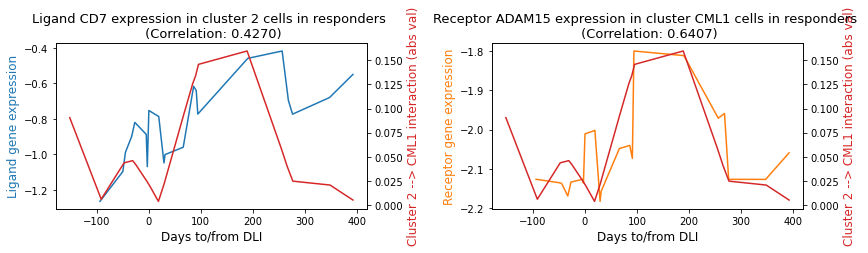



Ligand: UBC
Receptor: LDLR
Ligand-interaction correlation: 0.2856
Receptor-interaction correlation: 0.7366
Avg ligand/receptor-interaction correlation: 0.5111


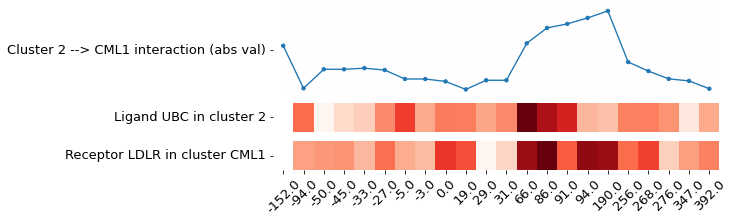

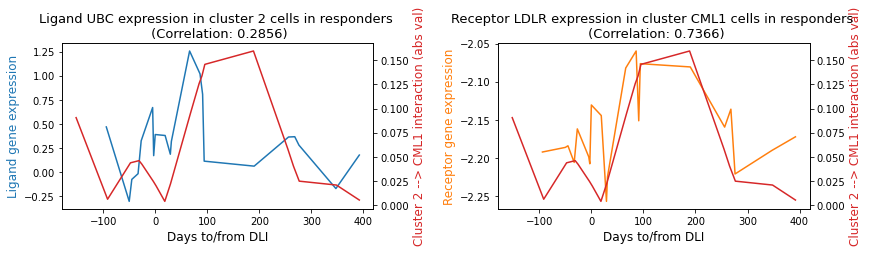



Ligand: CD55
Receptor: ADGRE2
Ligand-interaction correlation: 0.2288
Receptor-interaction correlation: 0.7017
Avg ligand/receptor-interaction correlation: 0.4652


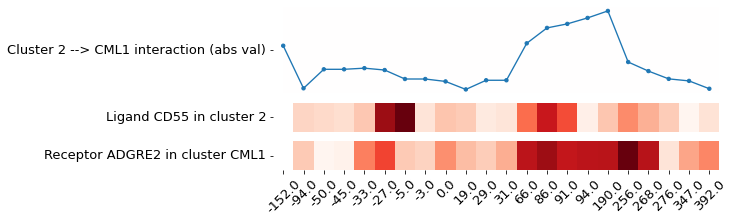

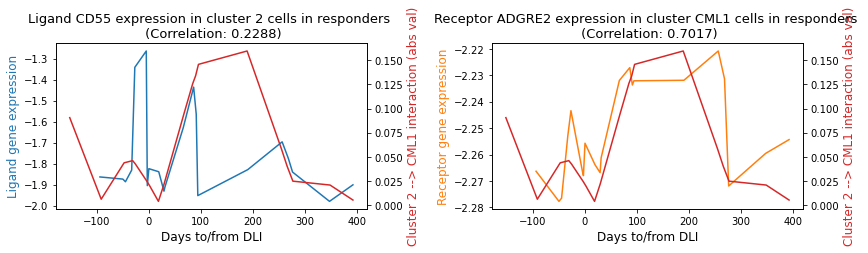



Ligand: HLA-B
Receptor: CANX
Ligand-interaction correlation: 0.3565
Receptor-interaction correlation: 0.5513
Avg ligand/receptor-interaction correlation: 0.4539


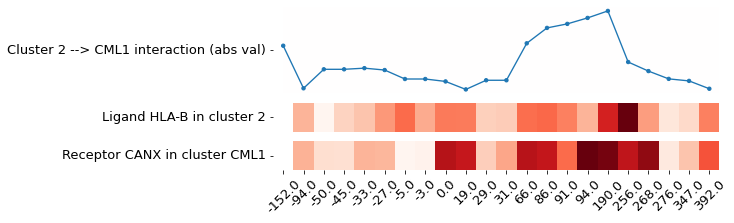

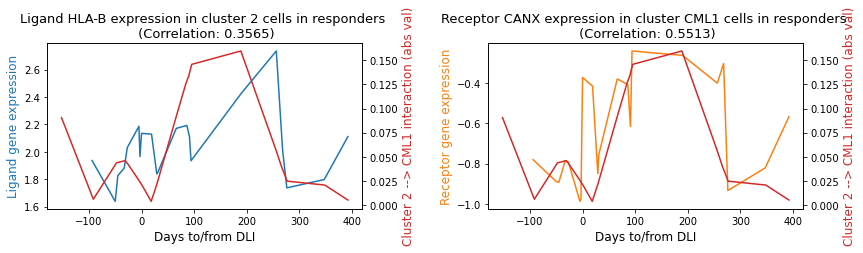



Ligand: HSPA8
Receptor: LDLR
Ligand-interaction correlation: 0.1400
Receptor-interaction correlation: 0.7366
Avg ligand/receptor-interaction correlation: 0.4383


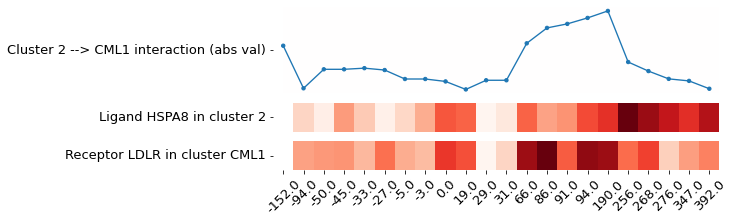

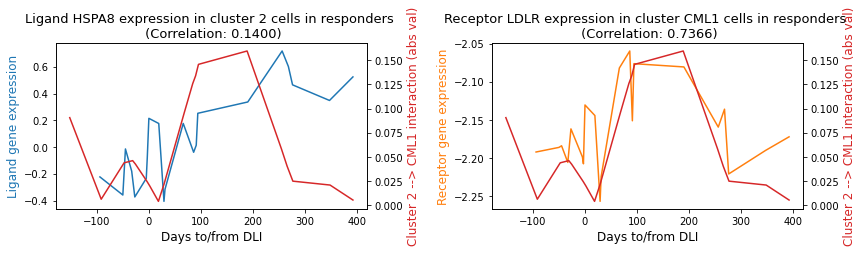



Ligand: LTA
Receptor: LTBR
Ligand-interaction correlation: 0.3116
Receptor-interaction correlation: 0.5578
Avg ligand/receptor-interaction correlation: 0.4347


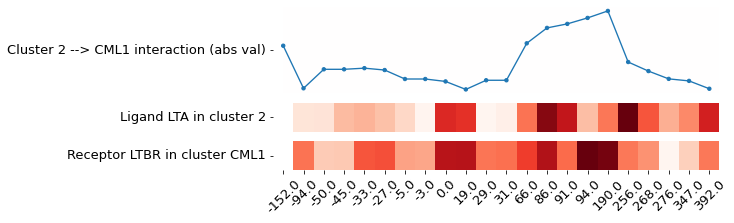

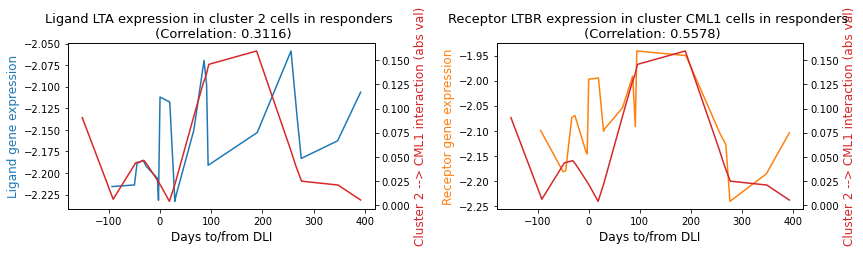



Ligand: IL6ST
Receptor: EPOR
Ligand-interaction correlation: 0.7499
Receptor-interaction correlation: 0.0995
Avg ligand/receptor-interaction correlation: 0.4247


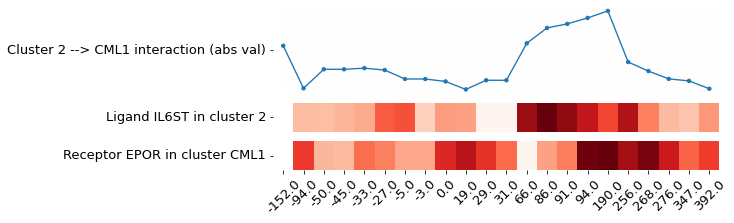

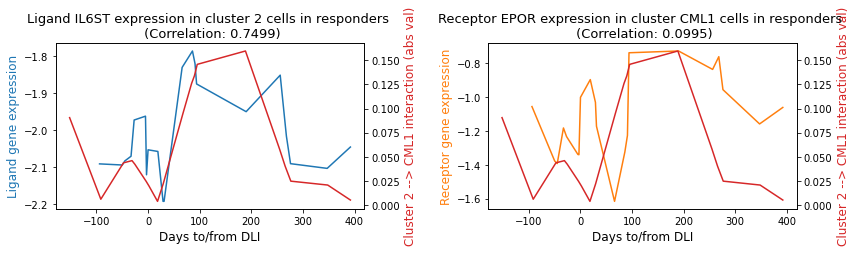



Ligand: CD96
Receptor: NECTIN2
Ligand-interaction correlation: 0.4327
Receptor-interaction correlation: 0.4055
Avg ligand/receptor-interaction correlation: 0.4191


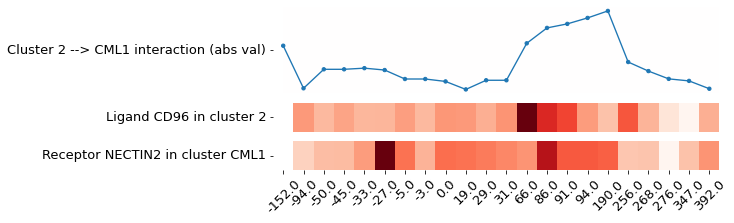

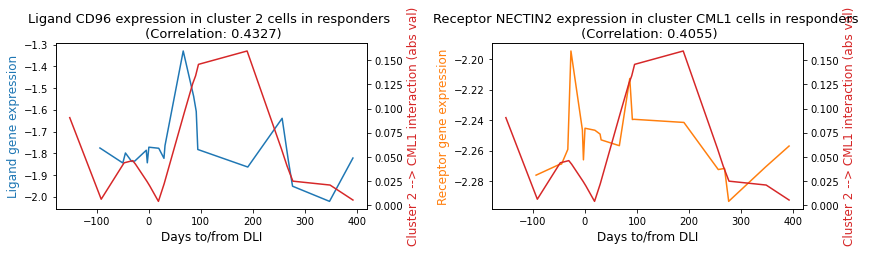



Ligand: TNF
Receptor: FAS
Ligand-interaction correlation: 0.1773
Receptor-interaction correlation: 0.6459
Avg ligand/receptor-interaction correlation: 0.4116


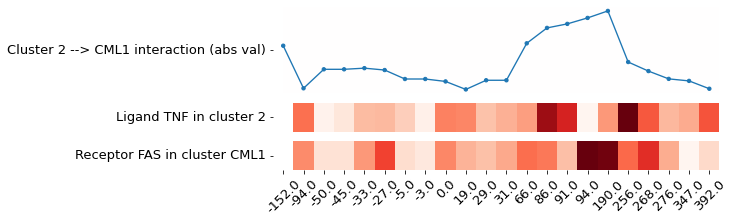

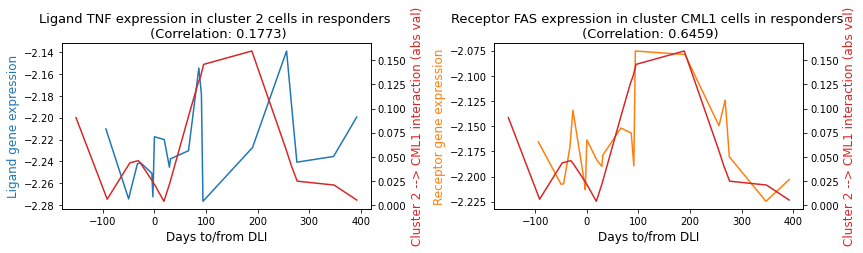



Ligand: IL16
Receptor: CD4
Ligand-interaction correlation: 0.1155
Receptor-interaction correlation: 0.7039
Avg ligand/receptor-interaction correlation: 0.4097


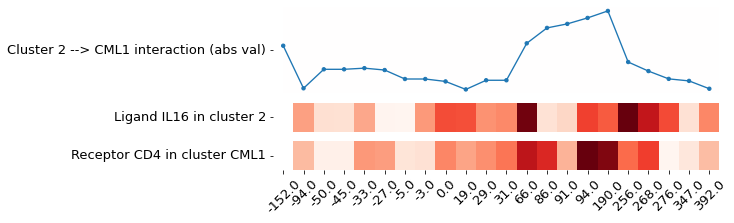

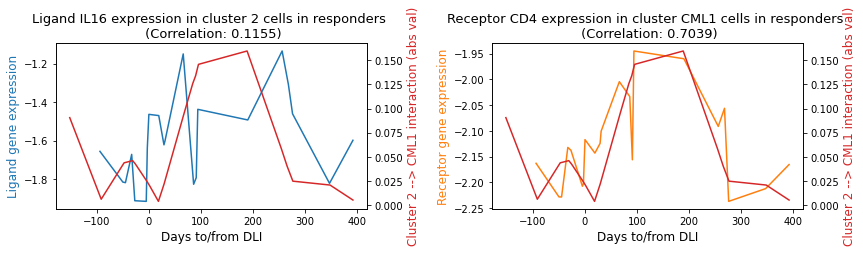



Ligand: UBC
Receptor: SMAD3
Ligand-interaction correlation: 0.2856
Receptor-interaction correlation: 0.4635
Avg ligand/receptor-interaction correlation: 0.3746


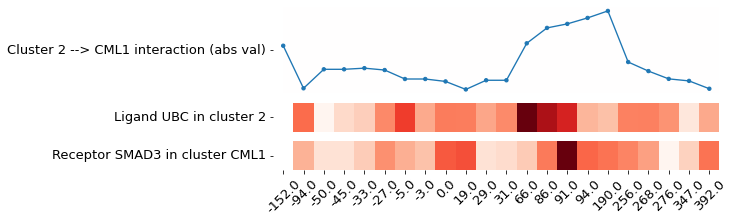

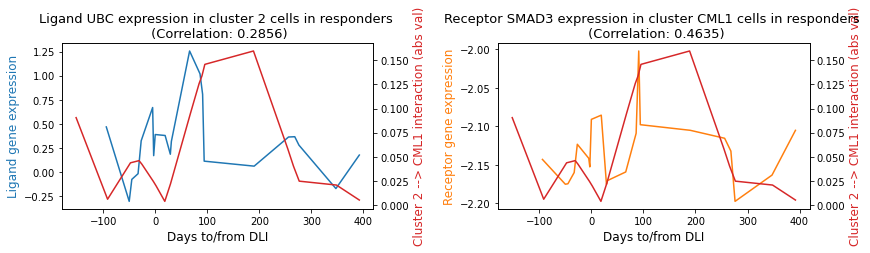



Ligand: TNF
Receptor: LTBR
Ligand-interaction correlation: 0.1773
Receptor-interaction correlation: 0.5578
Avg ligand/receptor-interaction correlation: 0.3676


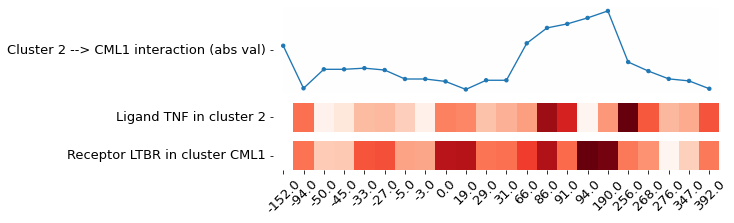

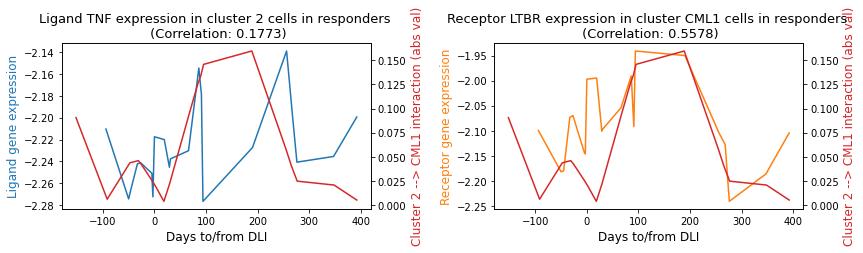



Ligand: IFITM1
Receptor: CD81
Ligand-interaction correlation: 0.3463
Receptor-interaction correlation: 0.3563
Avg ligand/receptor-interaction correlation: 0.3513


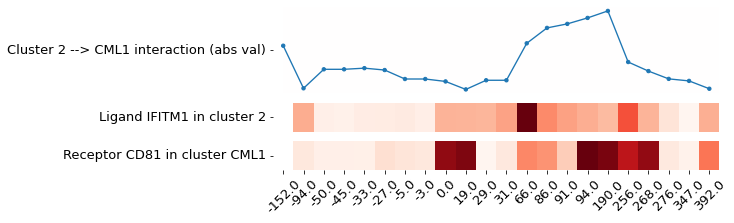

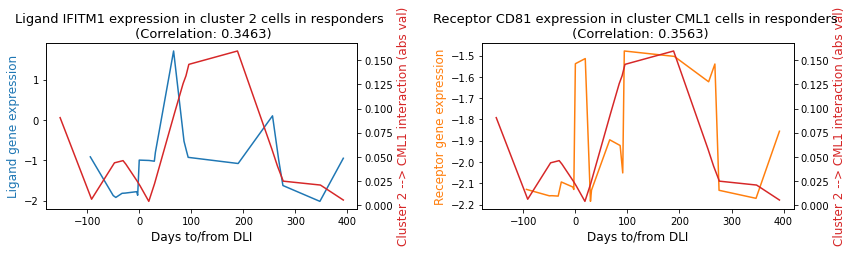



Ligand: LTA
Receptor: TNFRSF1A
Ligand-interaction correlation: 0.3116
Receptor-interaction correlation: 0.3695
Avg ligand/receptor-interaction correlation: 0.3406


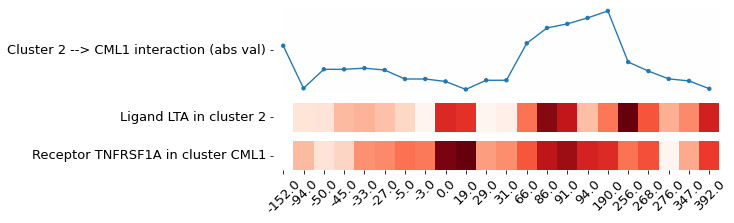

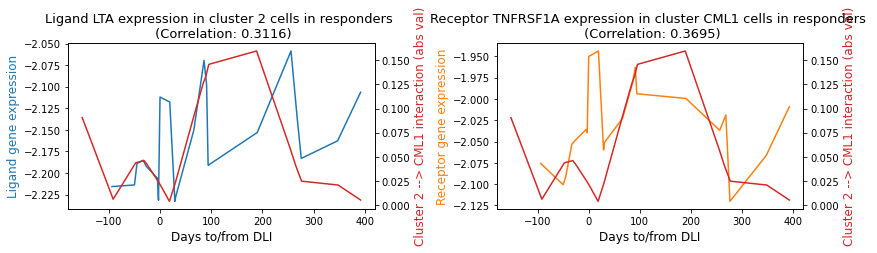



Ligand: HLA-A
Receptor: APLP2
Ligand-interaction correlation: 0.3102
Receptor-interaction correlation: 0.3586
Avg ligand/receptor-interaction correlation: 0.3344


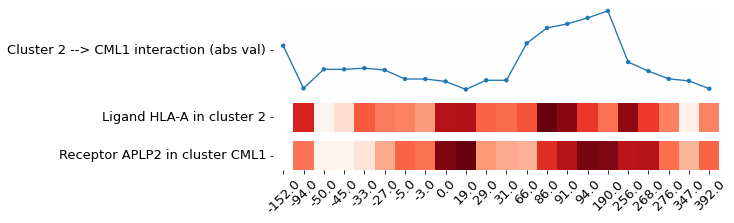

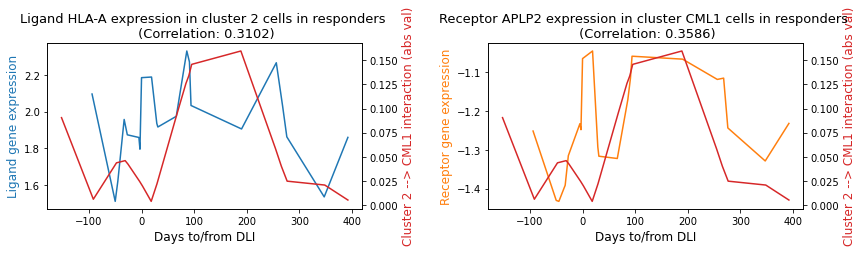



Ligand: RPS27A
Receptor: LDLR
Ligand-interaction correlation: -0.103
Receptor-interaction correlation: 0.7366
Avg ligand/receptor-interaction correlation: 0.3166


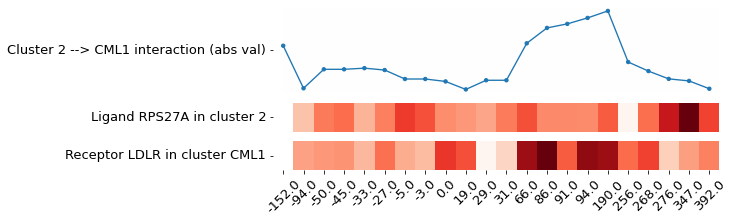

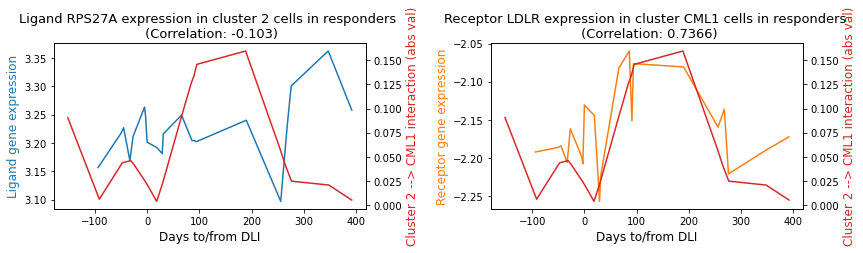



Ligand: CD55
Receptor: CR1
Ligand-interaction correlation: 0.2288
Receptor-interaction correlation: 0.3900
Avg ligand/receptor-interaction correlation: 0.3094


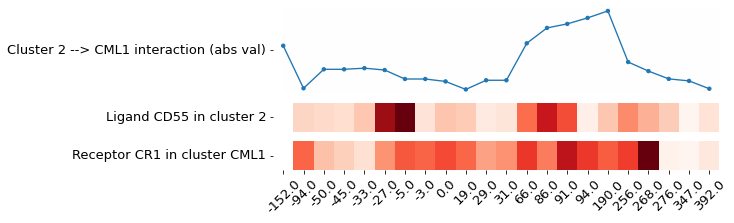

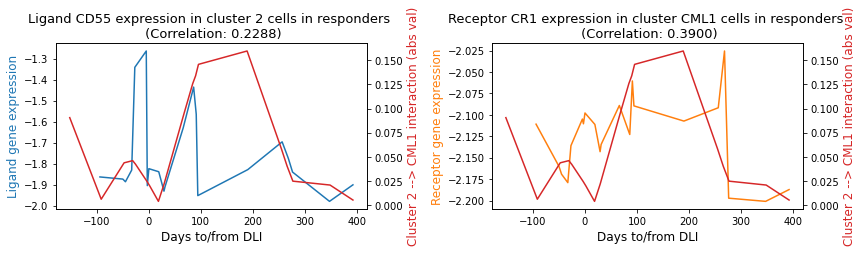



Ligand: CALM1
Receptor: FAS
Ligand-interaction correlation: -0.035
Receptor-interaction correlation: 0.6459
Avg ligand/receptor-interaction correlation: 0.3053


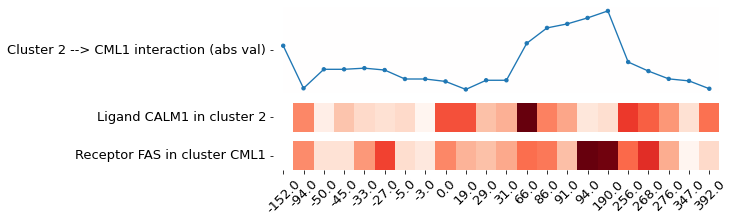

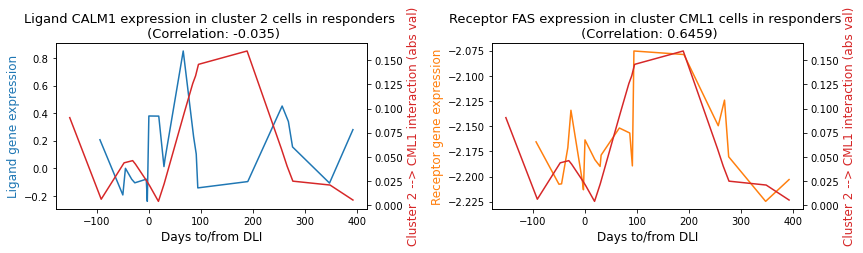



Ligand: CALM1
Receptor: AQP1
Ligand-interaction correlation: -0.035
Receptor-interaction correlation: 0.6254
Avg ligand/receptor-interaction correlation: 0.2951


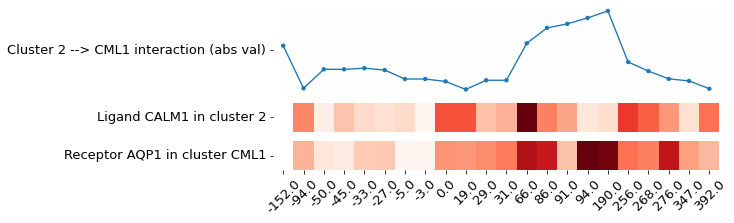

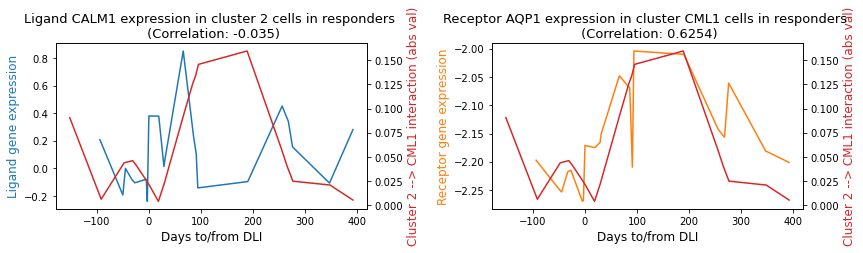



Ligand: CD226
Receptor: NECTIN2
Ligand-interaction correlation: 0.1564
Receptor-interaction correlation: 0.4055
Avg ligand/receptor-interaction correlation: 0.2810


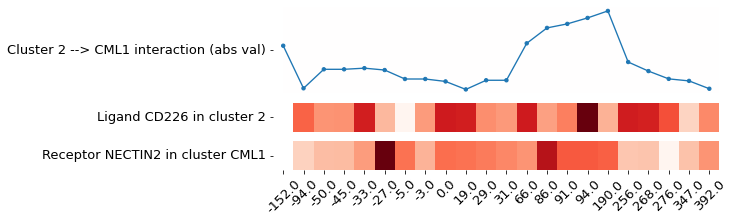

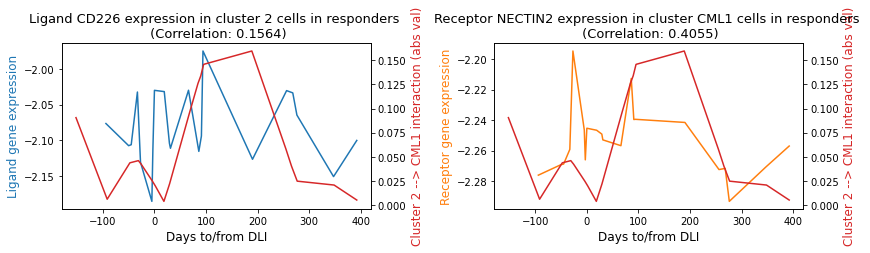



Ligand: TNF
Receptor: TNFRSF1A
Ligand-interaction correlation: 0.1773
Receptor-interaction correlation: 0.3695
Avg ligand/receptor-interaction correlation: 0.2734


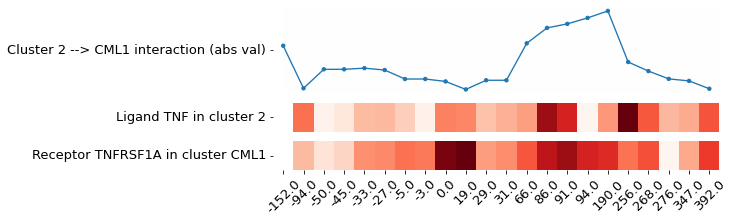

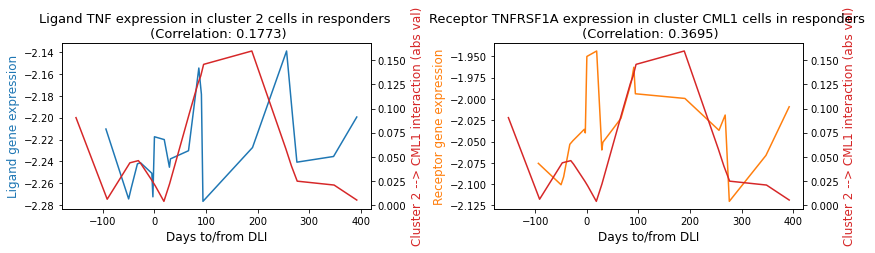



Ligand: HLA-C
Receptor: CD81
Ligand-interaction correlation: 0.1767
Receptor-interaction correlation: 0.3563
Avg ligand/receptor-interaction correlation: 0.2665


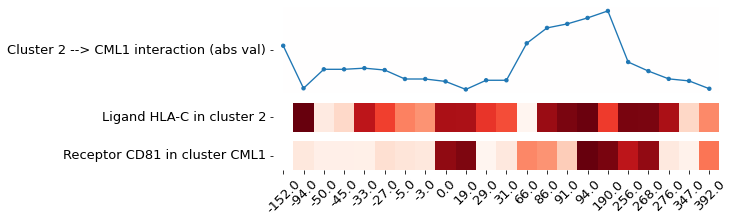

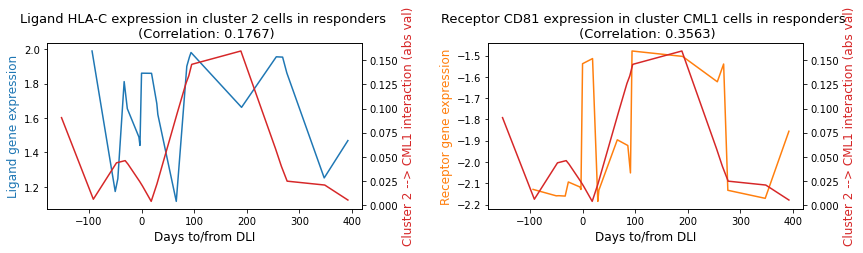



Ligand: SELL
Receptor: SELPLG
Ligand-interaction correlation: 0.1140
Receptor-interaction correlation: 0.4034
Avg ligand/receptor-interaction correlation: 0.2587


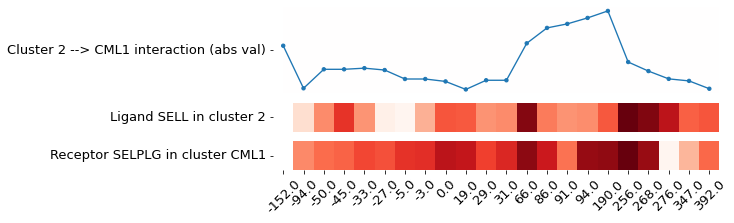

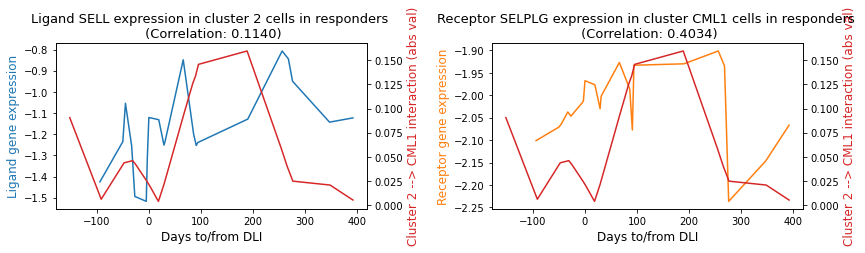



Ligand: B2M
Receptor: TFRC
Ligand-interaction correlation: 0.0319
Receptor-interaction correlation: 0.4820
Avg ligand/receptor-interaction correlation: 0.2569


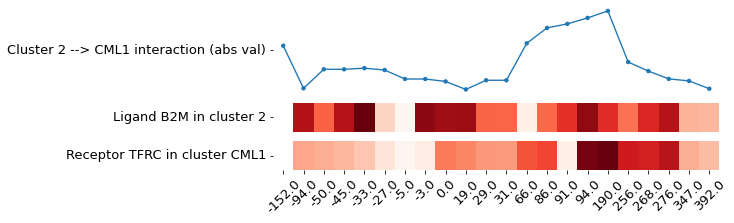

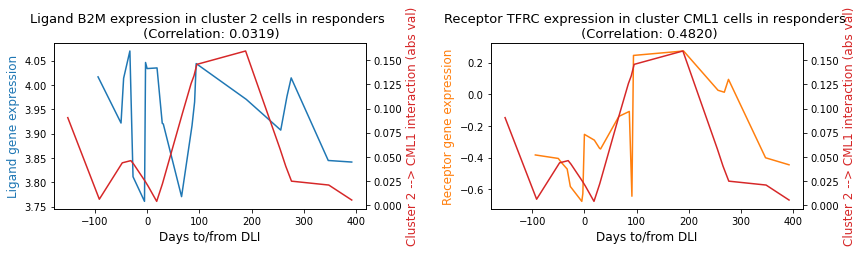



Ligand: SPTAN1
Receptor: PTPRA
Ligand-interaction correlation: 0.1316
Receptor-interaction correlation: 0.3770
Avg ligand/receptor-interaction correlation: 0.2543


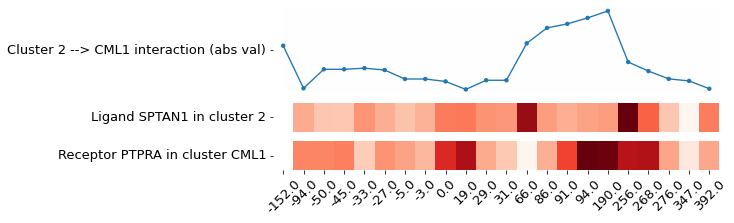

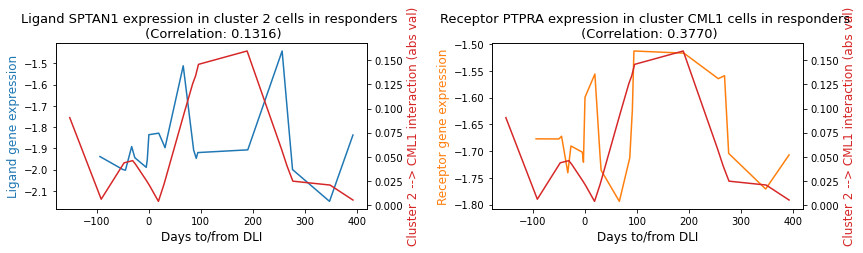



Ligand: UBA52
Receptor: LDLR
Ligand-interaction correlation: -0.250
Receptor-interaction correlation: 0.7366
Avg ligand/receptor-interaction correlation: 0.2431


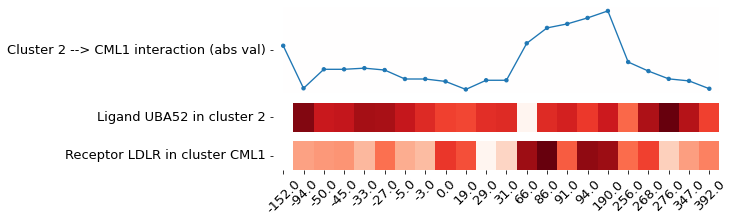

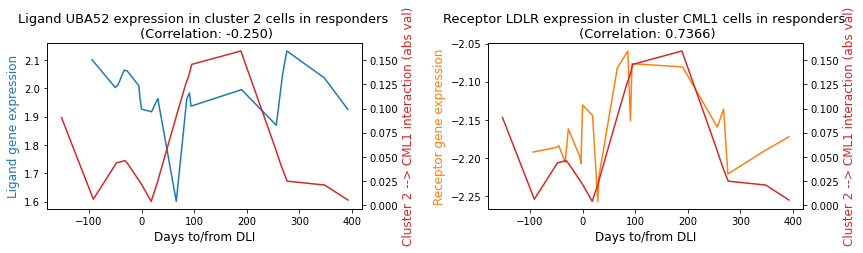



Ligand: ITGB1
Receptor: ENG
Ligand-interaction correlation: 0.0252
Receptor-interaction correlation: 0.4536
Avg ligand/receptor-interaction correlation: 0.2394


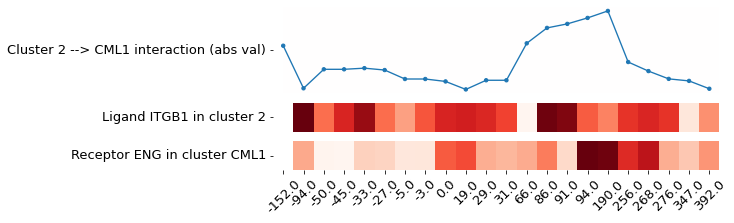

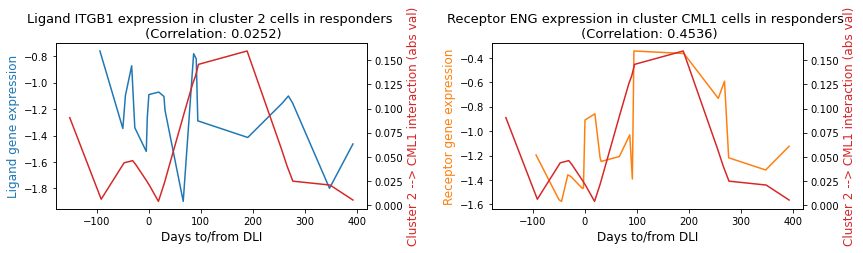



Ligand: FYN
Receptor: SPN
Ligand-interaction correlation: -0.027
Receptor-interaction correlation: 0.4184
Avg ligand/receptor-interaction correlation: 0.1954


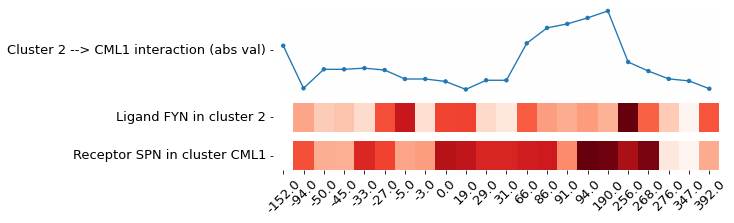

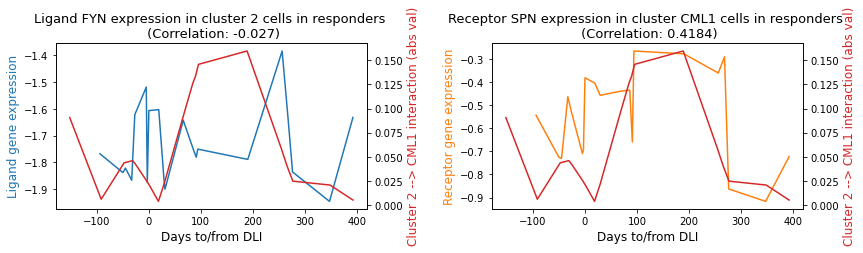



Ligand: SELL
Receptor: CD34
Ligand-interaction correlation: 0.1140
Receptor-interaction correlation: 0.2743
Avg ligand/receptor-interaction correlation: 0.1942


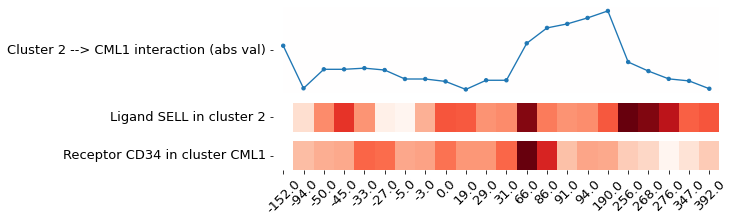

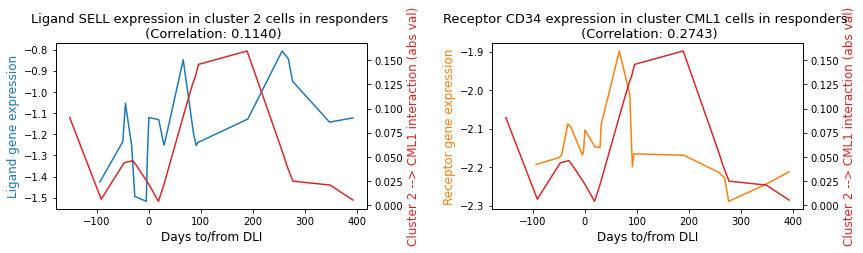

In [67]:
min_exp_threshold = -5
sliding_window_length = 2

source_cluster_index = list(clusters_of_interest).index(source_cluster)
target_cluster_index = list(clusters_of_interest).index(target_cluster)
source_cluster_cells = gene_exp_responders_df[metadata_responders_df['diisco_cluster'] == source_cluster]
target_cluster_cells = gene_exp_responders_df[metadata_responders_df['diisco_cluster'] == target_cluster]
source_target_inferred_interaction_abs_val = np.abs(W[:, target_cluster_index, source_cluster_index])

for _, rl_pair in ligand_receptor_corrs_with_interaction_df.iterrows():
    ligand_gene = rl_pair["Ligand"]
    receptor_gene = rl_pair["Receptor"]
    print("Ligand:", ligand_gene)
    print("Receptor:", receptor_gene)

    ligand_gene_exp = source_cluster_cells.loc[source_cluster_cells[ligand_gene] > min_exp_threshold, ligand_gene]
    ligand_days_to_dli = metadata_responders_df.loc[ligand_gene_exp.index, 'days_to_DLI']
    receptor_gene_exp = target_cluster_cells.loc[target_cluster_cells[receptor_gene] > min_exp_threshold, receptor_gene]
    receptor_days_to_dli = metadata_responders_df.loc[receptor_gene_exp.index, 'days_to_DLI']

    days_to_dli = sorted(ligand_days_to_dli.unique())
    sliding_window_mean_ligand_gene_exp = pd.Series({
        days: ligand_gene_exp[ligand_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
        for i, days in enumerate(days_to_dli)
    })
    ligand_closest_Xs_to_dli_dates = np.array([], dtype='int')
    for days in sliding_window_mean_ligand_gene_exp.index:
        closest_X = np.argmin(np.abs(X_test - days))
        ligand_closest_Xs_to_dli_dates = np.append(ligand_closest_Xs_to_dli_dates, closest_X)
    ligand_interaction_corr = np.corrcoef(sliding_window_mean_ligand_gene_exp.dropna(), 
                                          source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates][sliding_window_length-1:])

    days_to_dli = sorted(receptor_days_to_dli.unique())
    sliding_window_mean_receptor_gene_exp = pd.Series({
        days: receptor_gene_exp[receptor_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
        for i, days in enumerate(days_to_dli)
    })
    receptor_closest_Xs_to_dli_dates = np.array([], dtype='int')
    for days in sliding_window_mean_receptor_gene_exp.index:
        closest_X = np.argmin(np.abs(X_test - days))
        receptor_closest_Xs_to_dli_dates = np.append(receptor_closest_Xs_to_dli_dates, closest_X)
    receptor_interaction_corr = np.corrcoef(sliding_window_mean_receptor_gene_exp.dropna(), 
                                    source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_dli_dates][sliding_window_length-1:])

    heatmap_days_to_dli = sorted(set(ligand_days_to_dli.unique()).intersection(receptor_days_to_dli.unique()))
    heatmap_sliding_window_mean_ligand_gene_exp = sliding_window_mean_ligand_gene_exp[heatmap_days_to_dli]
    heatmap_sliding_window_mean_receptor_gene_exp = sliding_window_mean_receptor_gene_exp[heatmap_days_to_dli]
    rl_expression = pd.DataFrame(np.vstack([heatmap_sliding_window_mean_ligand_gene_exp, 
                                            heatmap_sliding_window_mean_receptor_gene_exp]), 
                                 columns=heatmap_days_to_dli)
    rl_expression.index = [f'Ligand {ligand_gene} in cluster {source_cluster}', 
                           f'Receptor {receptor_gene} in cluster {target_cluster}']

    print("Ligand-interaction correlation:", 
          str(ligand_interaction_corr[0, 1])[:6])
    print("Receptor-interaction correlation:", 
          str(receptor_interaction_corr[0, 1])[:6])
    print("Avg ligand/receptor-interaction correlation:", 
          str((ligand_interaction_corr[0, 1] + receptor_interaction_corr[0, 1]) / 2)[:6])

    plt.figure(figsize=(8, 3))
    gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 1]) 
    plt.subplot(gs[0])
    g = sns.heatmap([np.zeros_like(source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates])], 
                    yticklabels=[f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)'],
                    cmap='bwr', vmin=-1, center=0, vmax=1, cbar=False)
    ax2 = plt.twinx()
    sns.pointplot(x=sliding_window_mean_ligand_gene_exp.index,
                  y=source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates], 
                  ax=ax2, scale=0.5)
    plt.axis('off')
    g.set_yticklabels(g.get_yticklabels(), size = 13, rotation=0)
    g.set_xticklabels([], size = 13)
    g.set_xticks([])
    plt.subplot(gs[1])
    g = sns.heatmap(pd.DataFrame(rl_expression.iloc[0]).T, cmap='Reds', cbar=False)
    g.set_yticklabels(g.get_yticklabels(), size = 13, rotation=0)
    g.set_xticklabels([], size = 13)
    g.set_xticks([])
    plt.subplot(gs[2])
    g = sns.heatmap(pd.DataFrame(rl_expression.iloc[1]).T, cmap='Reds', cbar=False)
    g.set_yticklabels(g.get_yticklabels(), size = 13, rotation=0)
    g.set_xticklabels(g.get_xticklabels(), size = 13, rotation=45)
    plt.savefig(f'figures/CML/top_RL_pairs/{source_cluster}->{target_cluster}'\
                f'_{ligand_gene}_{receptor_gene}.eps', bbox_inches="tight")
    plt.show()

    plt.figure(figsize=(12, 3.5))
    ax1 = plt.subplot(1, 2, 1)
    ax2 = ax1.twinx()
    ax1.plot(sliding_window_mean_ligand_gene_exp.index, 
             sliding_window_mean_ligand_gene_exp, 
             color='tab:blue')
    ax1.set_ylabel('Ligand gene expression', fontsize=12, color='tab:blue')
    ax2.plot(X_test[ligand_closest_Xs_to_dli_dates], 
             source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates], color='tab:red')
    ax2.set_ylabel(f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)',
                   fontsize=12, color='tab:red')
    ax1.set_xlabel('Days to/from DLI', fontsize=12)
    plt.title(f'Ligand {ligand_gene} expression in cluster {source_cluster} cells in responders \n (Correlation: {str(ligand_interaction_corr[0, 1])[:6]})', 
              fontsize=13)

    ax1 = plt.subplot(1, 2, 2)
    ax2 = ax1.twinx()
    ax1.plot(sliding_window_mean_receptor_gene_exp.index, 
             sliding_window_mean_receptor_gene_exp, 
             color='tab:orange')
    ax1.set_ylabel('Receptor gene expression', fontsize=12, color='tab:orange')
    ax2.plot(X_test[receptor_closest_Xs_to_dli_dates], 
             source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_dli_dates], color='tab:red')
    ax2.set_ylabel(f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)',
                   fontsize=12, color='tab:red')
    ax1.set_xlabel('Days to/from DLI', fontsize=12)
    plt.title(f'Receptor {receptor_gene} expression in cluster {target_cluster} cells in responders \n (Correlation: {str(receptor_interaction_corr[0, 1])[:6]})', 
              fontsize=13)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.4)
    plt.savefig(f'figures/CML/top_RL_pairs/{source_cluster}->{target_cluster}'\
                f'_{ligand_gene}_{receptor_gene}_.eps', bbox_inches="tight")
    plt.show()

    print()
    print()